In [1]:
import numpy  as np
from astropy import table
from sinistra.astropy_helpers import symmetric_match

import betterplotlib as bpl
bpl.set_style()

In [2]:
m_51_data_krumholz = table.Table.read("../analysis/krumholz_review_data/chandar2016_m51.txt", format="ascii")
m_51_data_paper = table.Table.read("../analysis/krumholz_review_data/chandar_m15_paper_table.txt", format="ascii.cds")

Adjust RA/Dec to match between 2 catalogs. This offset was determine empirically. (by examining the plots below without this offset)

In [3]:
m_51_data_paper["RAdeg"] -= 5.924999999251668e-05
m_51_data_paper["DEdeg"] -= 0.00018720000000271853

Adjust effective radii to use the same distance

In [4]:
m_51_data_krumholz["FWHM(pc)"] *= 7.4 / 8.4

Then match the two Chandar16 catalogs

In [5]:
def distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

In [6]:
m_51_data_krumholz["RA"] = -99.9
m_51_data_krumholz["Dec"] = -99.9

n_found = 0
n_not_found = 0

for row_k in m_51_data_krumholz:
    x_k = row_k["x"]
    y_k = row_k["y"]
    
    found = False
    for row_p in m_51_data_paper:
        x_p = row_p["Xpix"]
        y_p = row_p["Ypix"]
        
        if distance(x_k, y_k, x_p, y_p) < 2:
            row_k["RA"] = row_p["RAdeg"]
            row_k["Dec"] = row_p["DEdeg"]
            found = True
            break
    if not found:
        n_not_found += 1
    else:
        n_found += 1
        
print(n_found, "found,", n_not_found, "not found")

203 found, 35 not found


In [7]:
m_51_data_krumholz_matched = m_51_data_krumholz[m_51_data_krumholz["RA"] > 0]

In [8]:
m_51_catalog_me = table.Table.read("../data/ngc5194-ngc5195-mosaic/size/final_catalog_final_30_pixels_psf_my_stars_15_pixels_2x_oversampled.txt", format="ascii.ecsv")

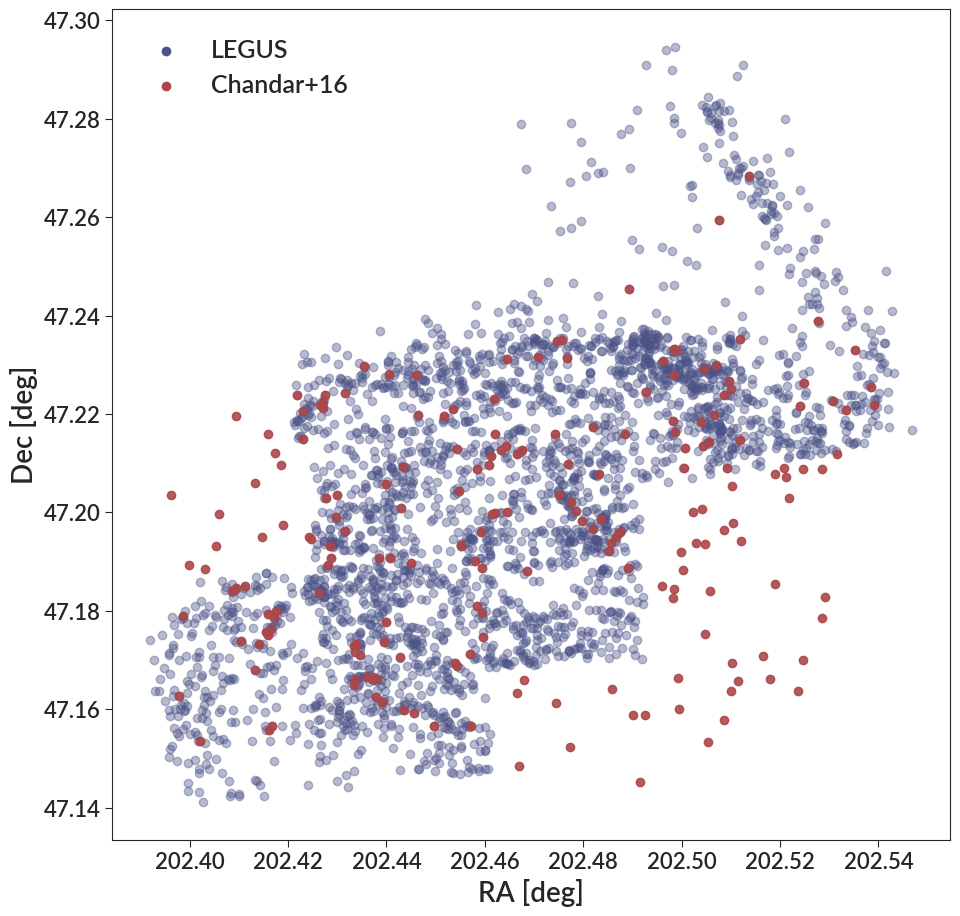

In [9]:
fig, ax = bpl.subplots(figsize=[10, 10])
ax.scatter(m_51_catalog_me["RA"], m_51_catalog_me["Dec"], label='LEGUS')
ax.scatter(m_51_data_krumholz_matched["RA"], m_51_data_krumholz_matched["Dec"], 
           c=bpl.color_cycle[3], label="Chandar+16")
ax.legend()
ax.equal_scale()
ax.add_labels("RA [deg]", "Dec [deg]")
fig.savefig("m51_overlap.png")

In [10]:
pixel_scale = 39.62 / 1000

In [11]:
m_51_catalog_match = symmetric_match(
    m_51_catalog_me,
    m_51_data_krumholz_matched,
    ra_col_1="RA",
    ra_col_2="RA",
    dec_col_1="Dec",
    dec_col_2="Dec",
    max_sep=pixel_scale * 3,
)

In [12]:
print(f"{len(m_51_catalog_match)}/{len(m_51_data_krumholz_matched)} cluster matched")

133/203 cluster matched


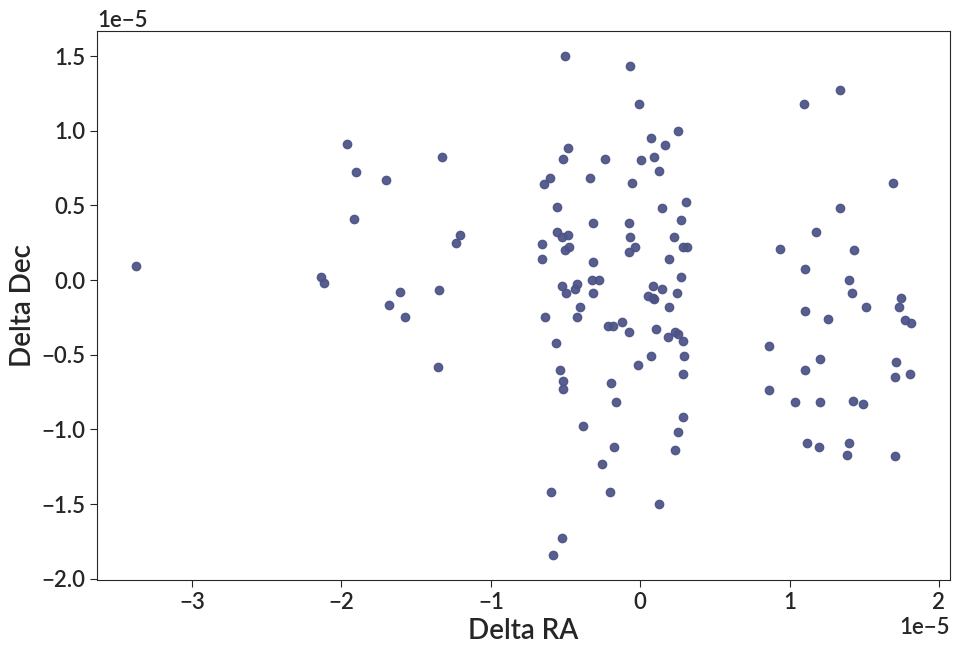

In [13]:
fig, ax = bpl.subplots()

ax.scatter(m_51_catalog_match["RA"] - m_51_catalog_match["RA_2"],
           m_51_catalog_match["Dec"] - m_51_catalog_match["Dec_2"])
ax.add_labels("Delta RA", "Delta Dec")
ax.equal_scale()

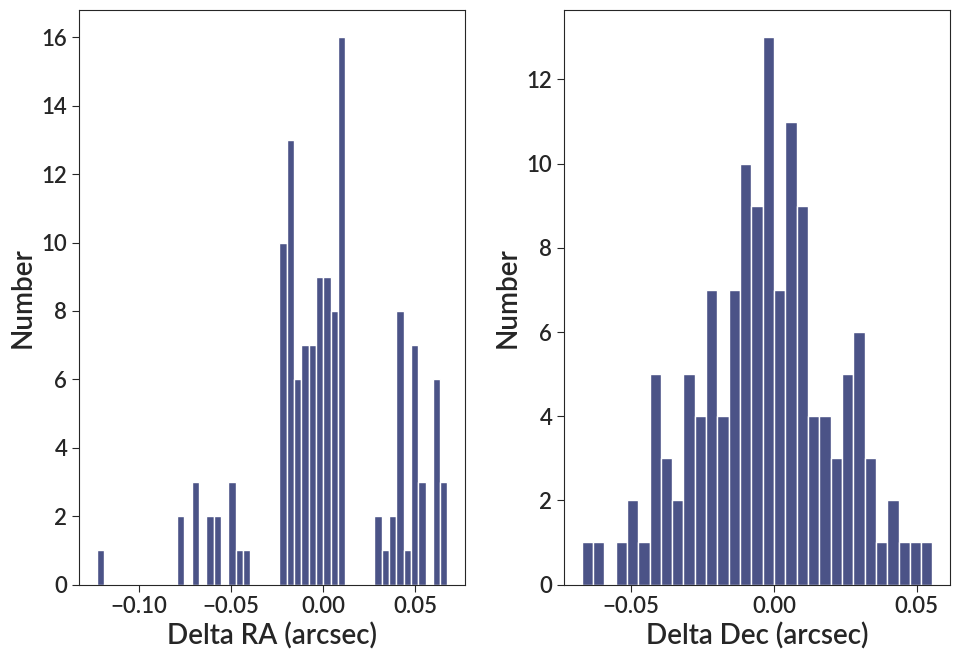

In [14]:
fig, axs = bpl.subplots(ncols=2)

axs[0].hist(3600 * (m_51_catalog_match["RA"] - m_51_catalog_match["RA_2"]), bin_size=0.1*pixel_scale)
axs[1].hist(3600 * (m_51_catalog_match["Dec"] - m_51_catalog_match["Dec_2"]), bin_size=0.1*pixel_scale)

axs[0].add_labels("Delta RA (arcsec)", "Number")
axs[1].add_labels("Delta Dec (arcsec)", "Number")

# Compare cluster populations

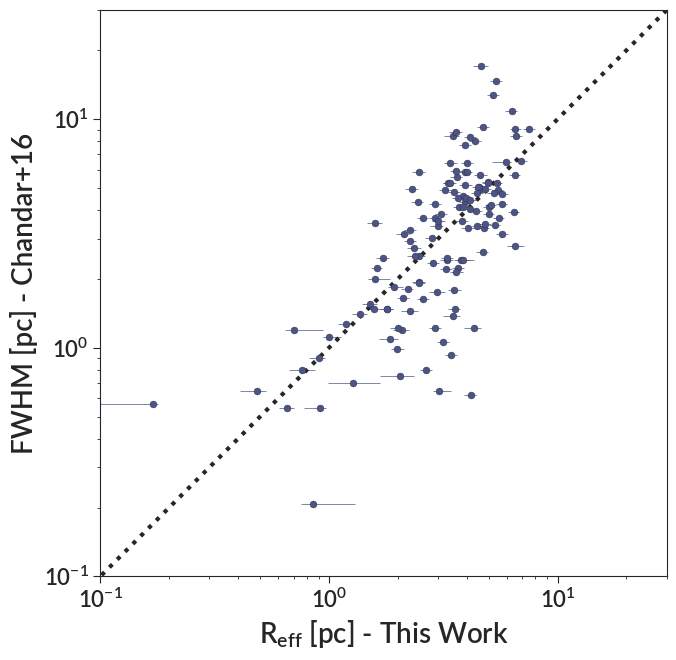

In [15]:
fig, ax = bpl.subplots()

ax.errorbar(
            x=m_51_catalog_match["r_eff_pc_rmax_15pix_best"],
            y=m_51_catalog_match["FWHM(pc)"],
            xerr=[m_51_catalog_match["r_eff_pc_rmax_15pix_e-"], m_51_catalog_match["r_eff_pc_rmax_15pix_e+"]],
            markersize=5,
            elinewidth=0.5,
        )

ax.plot([0.001, 100], [0.001, 100], ls=":", c=bpl.almost_black)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_limits(0.1, 30, 0.1, 30)
ax.equal_scale()
ax.add_labels("$R_{eff}$ [pc] - This Work", "FWHM [pc] - Chandar+16")
fig.savefig("m51_chandar_16_comparison.png")

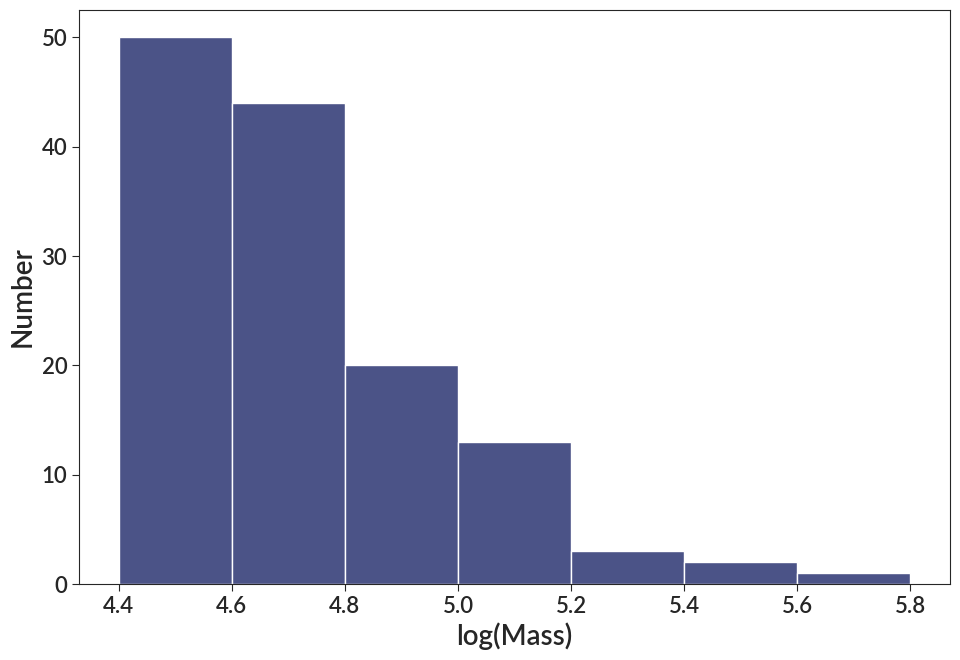

In [16]:
fig, ax = bpl.subplots()
ax.hist(m_51_catalog_match["logmass"], bin_size=0.2)
ax.add_labels("log(Mass)", "Number")